In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='whitegrid', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Load all the spike and value data

In [11]:
emp = pd.read_pickle("data/empirical.pkl")
dfs = []
for monkey in ['V', 'W']:
    for session in [0,1,2,3]:
        for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
            for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
values = pd.concat(dfs, ignore_index=True)

In [23]:
# values

In [22]:
nef_spikes = {}
for monkey in values['monkey'].unique():
    nef_spikes[monkey] = {}
    for session in values['session'].unique():
        session = int(session)
        nef_spikes[monkey][session] = {}
        for block in values.query("monkey==@monkey & session==@session")['block'].unique():
            block = int(block)
            nef_spikes[monkey][session][block] = {}
            for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                trial=int(trial)
                nef_spikes[monkey][session][block][trial] = {}
                nef_spikes[monkey][session][block][trial]['v'] = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['v'].sum(axis=0)  # sum over time
                nef_spikes[monkey][session][block][trial]['w'] = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['w'].sum(axis=0)  # sum over time
                nef_spikes[monkey][session][block][trial]['a'] = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['a'].sum(axis=0)  # sum over time
                nef_spikes[monkey][session][block][trial]['m'] = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['m'].sum(axis=0)  # sum over time
                nef_spikes[monkey][session][block][trial]['e'] = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['e'].sum(axis=0)  # sum over time
                nef_spikes[monkey][session][block][trial]['r'] = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['r'].sum(axis=0)  # sum over time
with open('data/nef_spikes/condensed.pkl', 'wb') as f:
    pickle.dump(nef_spikes, f)

In [18]:
# from pympler import asizeof
# size_bytes = asizeof.asizeof(spikes)
# size_mb = size_bytes / (1024 ** 2)
# print(f"Total size (deep): {size_mb:.6f} MB")

# Convert into arrays for regression

In [29]:
monkey = 'V'
session = 0
population = 'v'
variable = 'va'
X = []
Y = []
for block in values.query("monkey==@monkey & session==@session")['block'].unique():
    for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
        X.append(spikes[monkey][session][block][trial][population])
        Y.append(values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy())
X = np.array(X)
Y = np.array(Y)

In [30]:
print(X)
print(Y)

[[  1.   8.   8. ...  77.  85. 100.]
 [  2.  10.  10. ...  73.  82.  96.]
 [  0.   8.   8. ...  60.  69.  81.]
 ...
 [  6.  15.  15. ...  54.  63.  74.]
 [  0.   9.   9. ...  58.  69.  81.]
 [  2.  11.  11. ...  48.  55.  64.]]
[[-0.00463333]
 [ 0.12042123]
 [-0.08596638]
 ...
 [ 0.45770436]
 [ 0.24865819]
 [ 0.35074999]]


# Run regression

In [31]:
# Create a pipeline: Standardize features -> Ridge regression
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))

# Use negative MSE as the scoring metric
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# 10-fold cross-validation
cv_scores = cross_val_score(pipeline, X, Y, cv=10, scoring=scoring)

# Convert negative MSE to positive
mse_scores = -cv_scores
mean_mse = mse_scores.mean()

print("Cross-validated MSE scores:", mse_scores)
print("Mean cross-validated MSE:", mean_mse)

Cross-validated MSE scores: [0.00091218 0.00096521 0.00091454 0.00092926 0.00105134 0.00070382
 0.00086643 0.00100757 0.00098048 0.00088708]
Mean cross-validated MSE: 0.0009217927564013


# Investigate every combination of populations and variables over all monkeys and sessions

In [35]:
dfs = []
columns = ['monkey', 'session', 'population', 'variable', 'error']
for monkey in ['V', 'W']:
    for session in [0,1,2,3]:
        for population in ['v', 'w', 'a', 'm', 'e', 'r']:
            for variable in ['va', 'vb', 'vl', 'vr', 'wab', 'wlr', 'al', 'ar']:
                print(monkey, session, population, variable)
                X = []
                Y = []
                for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        X.append(spikes[monkey][session][block][trial][population])
                        Y.append(values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy())
                X = np.array(X)
                Y = np.array(Y)
                pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
                scoring = make_scorer(mean_squared_error, greater_is_better=False)
                cv_scores = cross_val_score(pipeline, X, Y, cv=10, scoring=scoring)
                mse = np.mean(-cv_scores)
                dfs.append(pd.DataFrame([[monkey, session, population, variable, mse]], columns=columns))
errors = pd.concat(dfs, ignore_index=True)

V 0 v va
V 0 v vb
V 0 v vl
V 0 v vr
V 0 v wab
V 0 v wlr
V 0 v al
V 0 v ar
V 0 w va
V 0 w vb
V 0 w vl
V 0 w vr
V 0 w wab
V 0 w wlr
V 0 w al
V 0 w ar
V 0 a va
V 0 a vb
V 0 a vl
V 0 a vr
V 0 a wab
V 0 a wlr
V 0 a al
V 0 a ar
V 0 m va
V 0 m vb
V 0 m vl
V 0 m vr
V 0 m wab
V 0 m wlr
V 0 m al
V 0 m ar
V 0 e va
V 0 e vb
V 0 e vl
V 0 e vr
V 0 e wab
V 0 e wlr
V 0 e al
V 0 e ar
V 0 r va
V 0 r vb
V 0 r vl
V 0 r vr
V 0 r wab
V 0 r wlr
V 0 r al
V 0 r ar
V 1 v va
V 1 v vb
V 1 v vl
V 1 v vr
V 1 v wab
V 1 v wlr
V 1 v al
V 1 v ar
V 1 w va
V 1 w vb
V 1 w vl
V 1 w vr
V 1 w wab
V 1 w wlr
V 1 w al
V 1 w ar
V 1 a va
V 1 a vb
V 1 a vl
V 1 a vr
V 1 a wab
V 1 a wlr
V 1 a al
V 1 a ar
V 1 m va
V 1 m vb
V 1 m vl
V 1 m vr
V 1 m wab
V 1 m wlr
V 1 m al
V 1 m ar
V 1 e va
V 1 e vb
V 1 e vl
V 1 e vr
V 1 e wab
V 1 e wlr
V 1 e al
V 1 e ar
V 1 r va
V 1 r vb
V 1 r vl
V 1 r vr
V 1 r wab
V 1 r wlr
V 1 r al
V 1 r ar
V 2 v va
V 2 v vb
V 2 v vl
V 2 v vr
V 2 v wab
V 2 v wlr
V 2 v al
V 2 v ar
V 2 w va
V 2 w vb
V 2 w vl
V 2 w vr
V 

In [36]:
errors.to_pickle("data/nef_spikes/errors.pkl")

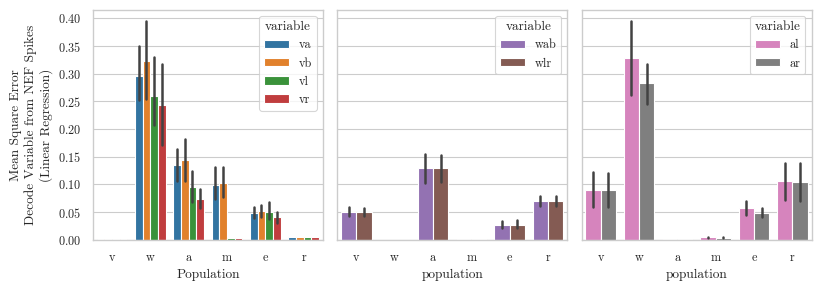

In [44]:
v_variables = ['va', 'vb', 'vl', 'vr']
w_variables = ['wab', 'wlr']
a_variables = ['al', 'ar']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(errors.query("variable in @v_variables"), x='population', y='error', hue='variable', ax=axes[0], palette=palette[:4])
sns.barplot(errors.query("variable in @w_variables"), x='population', y='error', hue='variable', ax=axes[1], palette=palette[4:6])
sns.barplot(errors.query("variable in @a_variables"), x='population', y='error', hue='variable', ax=axes[2], palette=palette[6:8])
fig.tight_layout()
axes[0].set(ylabel="Mean Square Error\nDecode Variable from NEF Spikes\n(Linear Regression)", xlabel='Population')
fig.savefig("plots/nef_spikes_decode_nef_variables.jpg", dpi=600)

# Monkey spikes and RL variables

In [10]:
# emp_spikes = {}
# for monkey in rl_values['monkey'].unique():
#     emp_spikes[monkey] = {}
#     for session in rl_values['session'].unique():
#         session = int(session)
#         emp_spikes[monkey][session] = {}
#         for block in rl_values.query("monkey==@monkey & session==@session")['block'].unique():
#             block = int(block)
#             emp_spikes[monkey][session][block] = {}
#             for trial in rl_values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
#                 trial=int(trial)
#                 emp_spikes[monkey][session][block][trial] = np.load(
#                     f"data/emp_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['spikes']
# with open('data/emp_spikes/condensed.pkl', 'wb') as f:
#     pickle.dump(emp_spikes, f)

In [25]:
dfs = []
for monkey in ['V', 'W']:
    for session in [0,1,2,3]:
        for block in range(1, 25):
            for trial in range(1, 81):
                file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                try:
                    dfs.append(pd.read_pickle(f'data/emp_spikes/{file}_values.pkl'))
                except:
                    # print(f"skipping monkey {monkey}, session {session}, block {block}, trial {trial}")
                    pass
rl_values = pd.concat(dfs, ignore_index=True)

with open('data/emp_spikes/condensed.pkl', 'rb') as file:
    emp_spikes = pickle.load(file)

dfs = []
columns = ['monkey', 'session', 'variable', 'error']
for monkey in ['V', 'W']:
    for session in [0,1,2,3]:
        for variable in ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar', 'dvs', 'dva']:
            print(monkey, session, variable)
            X = []
            Y = []
            for block in rl_values.query("monkey==@monkey & session==@session")['block'].unique():
                for trial in rl_values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                    try:
                        X.append(emp_spikes[monkey][session][block][trial])
                        Y.append(rl_values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy())
                    except:
                        # print(monkey, session, variable, block, trial)
                        pass
            X = np.array(X)
            Y = np.array(Y)
            # print(X, Y)
            pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
            scoring = make_scorer(mean_squared_error, greater_is_better=False)
            cv_scores = cross_val_score(pipeline, X, Y, cv=10, scoring=scoring)
            mse = np.mean(-cv_scores)
            dfs.append(pd.DataFrame([[monkey, session, variable, mse]], columns=columns))
emp_errors = pd.concat(dfs, ignore_index=True)
emp_errors.to_pickle("data/emp_spikes/errors.pkl")

V 0 va
V 0 vb
V 0 vl
V 0 vr
V 0 w
V 0 al
V 0 ar
V 0 dvs
V 0 dva
V 1 va
V 1 vb
V 1 vl
V 1 vr
V 1 w
V 1 al
V 1 ar
V 1 dvs
V 1 dva
V 2 va
V 2 vb
V 2 vl
V 2 vr
V 2 w
V 2 al
V 2 ar
V 2 dvs
V 2 dva
V 3 va
V 3 vb
V 3 vl
V 3 vr
V 3 w
V 3 al
V 3 ar
V 3 dvs
V 3 dva
W 0 va
W 0 vb
W 0 vl
W 0 vr
W 0 w
W 0 al
W 0 ar
W 0 dvs
W 0 dva
W 1 va
W 1 vb
W 1 vl
W 1 vr
W 1 w
W 1 al
W 1 ar
W 1 dvs
W 1 dva
W 2 va
W 2 vb
W 2 vl
W 2 vr
W 2 w


/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line

W 2 al


/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line

W 2 ar


/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line

W 2 dvs


/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line

W 2 dva


/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/psipeter/arbitration/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line

W 3 va
W 3 vb
W 3 vl
W 3 vr
W 3 w
W 3 al
W 3 ar
W 3 dvs
W 3 dva


/tmp/ipykernel_57093/3901655498.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(emp_errors, x='variable', y='error', hue='variable', ax=axes, palette=palette)


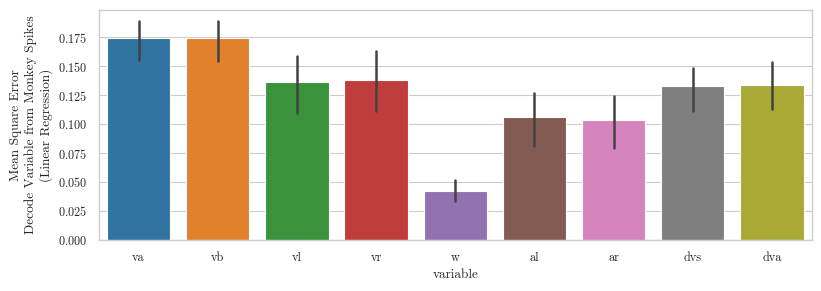

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(emp_errors, x='variable', y='error', hue='variable', ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel="Mean Square Error\nDecode Variable from Monkey Spikes\n(Linear Regression)")
fig.savefig("plots/emp_spikes_decode_rl_variables.jpg", dpi=600)